In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.utils.data.dataloader as dataloader

import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

In [2]:
# Define the root directory of the dataset
data_set_root = "../data"

# Define transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize image data with mean 0.5 and standard deviation 0.5
])

# Load the MNIST dataset
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Specify the number of examples to select randomly
num_of_examples = 100

# Randomly select indices from the dataset
rand_perm = torch.randperm(dataset.data.shape[0])[:num_of_examples]

# Extract and concatenate the images of randomly selected examples into a tensor
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1, -1) for i in rand_perm])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:13<00:00, 723297.13it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 249189.90it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1145314.92it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4717812.97it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



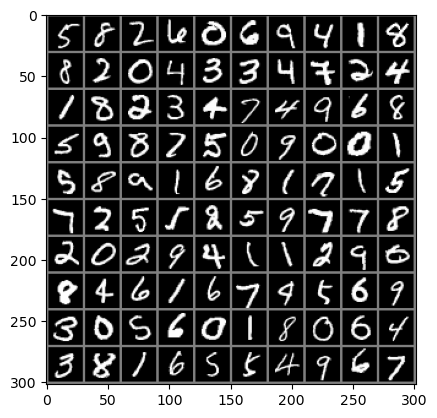

In [3]:
# Lets visualise the images
out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Indexing a Dataset
At this point we would be familiar with indexing a tensor/array with an integer index!

In [4]:
# Define our index value
q_index = 10

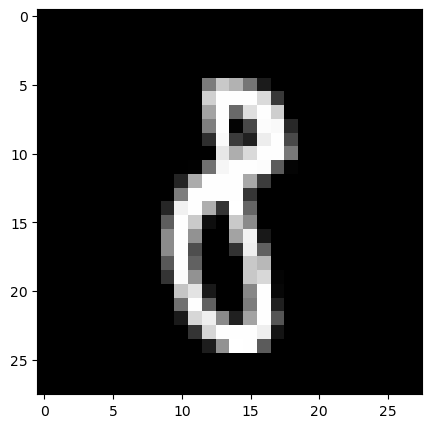

In [5]:
# Lets visualise the image at this index!
plt.figure(figsize = (5,5))
_ = plt.imshow(dataset_tensor[q_index].reshape(28, 28).numpy(), cmap="gray")

## Indexing a Dataset with Matrix Multiplication
Did you know we can do the same thing, but using Matrix multiplication?

In [6]:
# Convert the index into a one-hot-coded vector with the same length as the number of samples
# This will be our "query" vector (q)
q_one_hot_vec = F.one_hot(torch.tensor([q_index]), num_of_examples)

# Create a unique one-hot-coded vector for every image in our dataset
# These will be our "key" vectors (k)
k_one_hot = F.one_hot(torch.arange(num_of_examples), num_of_examples)

# Randomly shuffle the keys and dataset to demonstrate that we can find the target image
# even in a randomly organized dataset
rand_perm = torch.randperm(num_of_examples)
k_one_hot = k_one_hot[rand_perm]
dataset_tensor_random = dataset_tensor[rand_perm]

In [7]:
# Multiply our key vector with the dataset
# Perform matrix multiplication between the query vector (q_one_hot_vec) and the transpose of the key vectors (k_one_hot.t())
index_map = torch.mm(q_one_hot_vec, k_one_hot.t()).float()

# Perform matrix multiplication between the resulting index map and the randomly shuffled dataset
output = torch.mm(index_map, dataset_tensor_random)

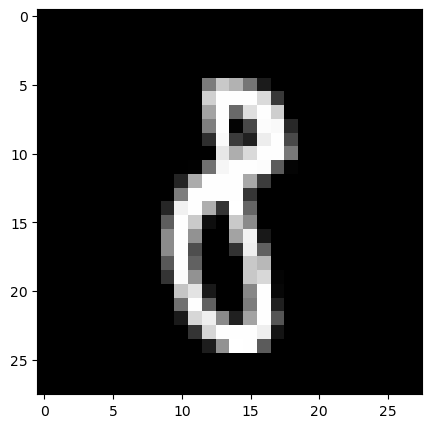

In [8]:
# Visualize the image at the specified index
plt.figure(figsize=(5, 5))
_ = plt.imshow(output.reshape(28, 28).numpy(), cmap="gray")

## Attention as a "Soft" Look-up
What if we don't use "hard" one-hot coded vectors?

In [9]:
# Define the size for each of the vectors
vec_size = 512

# Create a random query vector
q_random_vec = torch.randn(1, vec_size)

# Create a random key vector for each image in the dataset
random_keys = torch.randn(num_of_examples, vec_size)

# Calculate an "attention map" by performing matrix multiplication between the 
# query vector and the transpose of the key vectors
attention_map = torch.mm(q_random_vec, random_keys.t()).float()

# Calculate the Softmax over the attention map to obtain a probability distribution
attention_map = F.softmax(attention_map, 1)

# Use the attention map to perform a soft "indexing" over the dataset by 
# multiplying it with the dataset tensor
output = torch.mm(attention_map, dataset_tensor)

In [10]:
print("The largest Softmax value is %f" % attention_map.max().item())

The largest Softmax value is 0.999900


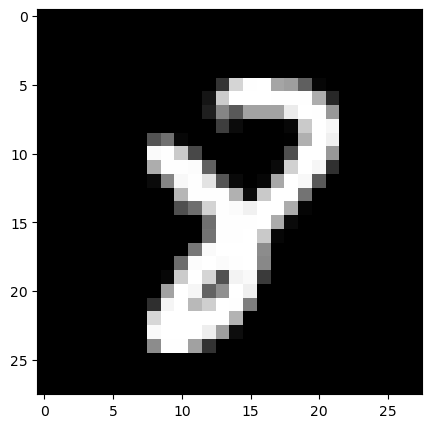

In [11]:
# Lets visualise the image we get as a result!
plt.figure(figsize = (5,5))
_ = plt.imshow(output.reshape(28, 28).numpy(), cmap="gray")

## Multiple Queries
We can also perform multiple queries at the same time

In [12]:
# Define the size for each of the vectors
vec_size = 32

# Number of Queries
num_q = 8

# Create random query vectors
q_random_vec = torch.randn(num_q, vec_size)

# Create a random key vector for each image in the dataset
random_keys = torch.randn(num_of_examples, vec_size)

# Calculate an "attention map" by performing matrix multiplication between the 
# query vectors and the transpose of the key vectors
attention_map = torch.mm(q_random_vec, random_keys.transpose(0, 1)).float()

# Calculate the Softmax over the attention map to obtain a probability distribution
attention_map = F.softmax(attention_map, -1)

# Use the attention map to perform a soft "indexing" over the dataset by 
# multiplying it with the dataset tensor
output = torch.mm(attention_map, dataset_tensor)

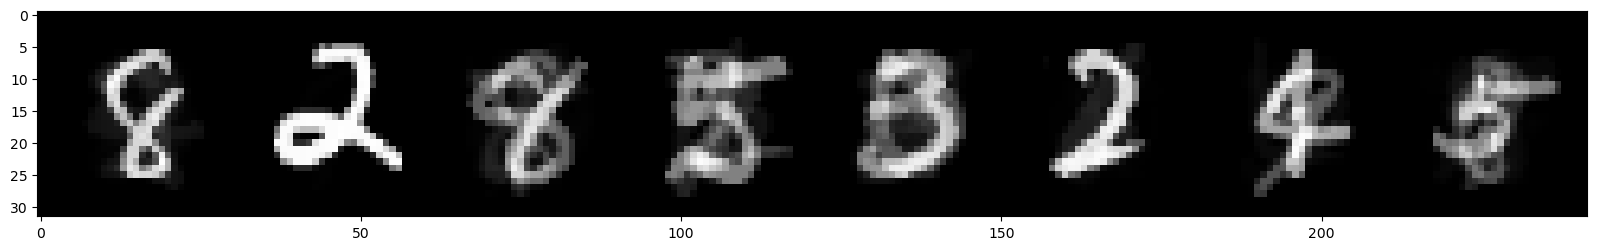

In [13]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(output.reshape(num_q, 1, 28, 28), 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Multi-Headed Attention
We can also perform Attention multiple times in parallel!

In [14]:
# Define the size for each of the vectors
vec_size = 32

# Number of Queries
num_q = 8

# Number of Heads
num_heads = 4

# Create random query vectors
q_random_vec = torch.randn(num_heads, num_q, vec_size)

# Create a random key vector for each image in the dataset
random_keys = torch.randn(num_heads, num_of_examples, vec_size)

# Calculate an "attention map" by performing batch matrix multiplication between the 
# query vectors and the transpose of the key vectors
attention_map = torch.bmm(q_random_vec, random_keys.transpose(1, 2)).float()

# Calculate the Softmax over the attention map to obtain a probability distribution
attention_map = F.softmax(attention_map, 2)

# Use the attention map to perform a soft "indexing" over the dataset by 
# multiplying it with the dataset tensor
output = torch.bmm(attention_map, dataset_tensor.unsqueeze(0).expand(num_heads, num_of_examples, -1))

# Reshape the output tensor for visualization
out_reshape = output.reshape(num_heads, num_q, 28, 28).transpose(1, 2).reshape(num_heads, 1, 28, num_q*28)

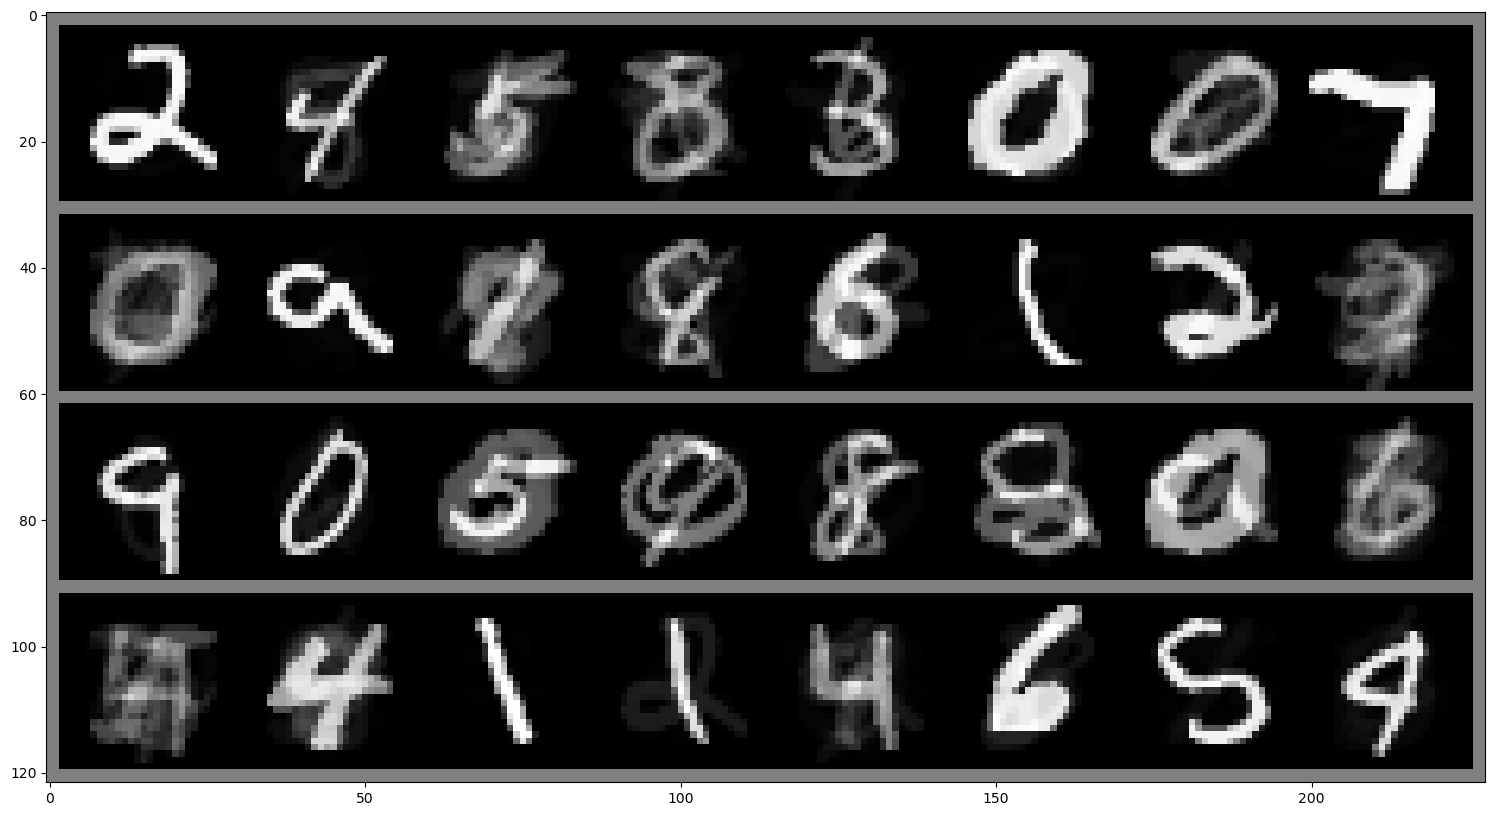

In [15]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(out_reshape, 1, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Pytorch Multi-Head Attention
Of course Pytorch has it's own implementation of Multi-Head Attention!<br>

[Pytorch MultiheadAttention](https://pytorch.org/docs/2.1/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention)

We'll go into more detail on how to use it in later examples!

In [16]:
# Define the size for each of the vectors
vec_size = 32

# Number of Heads
num_heads = 8

# Batch Size
batch_size = 32

# Create a batch of a single random query vector
query = torch.randn(batch_size, 1, num_heads * vec_size)

# Create random key and value vectors for each image in the dataset
key = torch.randn(batch_size, num_of_examples, num_heads * vec_size)
value = torch.randn(batch_size, num_of_examples, num_heads * vec_size)

# Initialize a MultiheadAttention module with specified parameters
multihead_attn = nn.MultiheadAttention(num_heads * vec_size, num_heads, batch_first=True)

In [17]:
# Perform a forward pass through the Multi-Head Attention module
# Returns the attention output and the attention weights
attn_output, attn_output_weights = multihead_attn(query, key, value, average_attn_weights=False)

In [18]:
# Print the shapes of the output of the forward pass from Multi-Head Attention module

# Softmaxed "attention mask" shape
print("Softmax Attention Mask:", attn_output_weights.shape)

# Attention output shape
print("Attention Output:", attn_output.shape)

Softmax Attention Mask: torch.Size([32, 8, 1, 100])
Attention Output: torch.Size([32, 1, 256])


In [19]:
# Each query/key/value vector is passed through a "projection" aka a learnable linear layer before
# the attention mechanism 
# As they are all the same size Pytorch creates a single block of parameters splits it into 3 
# Before doing a forward pass of each*
print("Projection weight size", multihead_attn.in_proj_weight.shape)

# *Most of the time, doing a deep dive into the implementation Pytorch tries to do a lot of optimisation
# to try and be efficient as possible depending on the use-case

Projection weight size torch.Size([768, 256])


## Train a Multi-Head Attention
Lets train a model with attention that when given an image will try to find an image within its corresponding fixed "dataset" that closely matches!

In [20]:
class AttentionTest(nn.Module):
    def __init__(self, num_of_examples=100, embed_dim=784, num_heads=4):
        super(AttentionTest, self).__init__()
        
        # Define an MLP for processing image data
        self.img_mlp = nn.Sequential(
            nn.Linear(784, embed_dim),   # Linear layer to embed image data into a lower-dimensional space
            nn.LayerNorm(embed_dim),     # Layer normalization to normalize the embedded features
            nn.ELU(),                    # ELU activation function for introducing non-linearity
            nn.Linear(embed_dim, embed_dim)  # Another linear transformation for further processing
        )
        
        # Define the Multi-Head Attention mechanism
        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim,     # Dimensionality of the embedding space
            num_heads=num_heads,     # Number of attention heads
            batch_first=True         # Whether the input is batch-first or sequence-first
        )

    def forward(self, img, values):
        # Process the input image and values through the MLP layers
        img_ = self.img_mlp(img)
        values_ = self.img_mlp(values)

        # Apply the Multi-Head Attention mechanism
        attn_output, attn_output_weights = self.mha(img_, values_, values_)
        
        # Compute the output using the attention weights and the original values
        output = torch.bmm(attn_output_weights, values)

        return output, attn_output_weights

In [21]:
# Define the dimensionality of the embedding space
embed_dim = 256

# Define the number of attention heads
num_heads = 1

# Define the batch size
batch_size = 64

In [22]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Create a DataLoader for training the model
train_loader = dataloader.DataLoader(
    dataset,                   # Dataset to load
    shuffle=True,              # Shuffle the data for each epoch
    batch_size=batch_size,     # Batch size for training
    num_workers=4,             # Number of processes to use for data loading
    drop_last=True             # Drop the last incomplete batch if it's smaller than the batch size
)

## Initialize Model and Optimizer

In [23]:
# Create an instance of the AttentionTest model
mha_model = AttentionTest(
    num_of_examples=num_of_examples,   # Number of examples in the dataset
    embed_dim=embed_dim,               # Dimensionality of the embedding space
    num_heads=num_heads                # Number of attention heads
).to(device)                           # Move the model to the specified device

# Define the Adam optimizer for training the model
optimizer = optim.Adam(
    mha_model.parameters(),  # Parameters to optimize
    lr=1e-4                   # Learning rate
)

# List to store the training loss for each epoch
loss_logger = []

# Duplicate the data value tensor for each batch element and move it to the specified device
values_tensor = dataset_tensor.unsqueeze(0).expand(batch_size, num_of_examples, -1).to(device)

## Training

In [24]:
# Set the model to training mode
mha_model.train()

# Loop through 10 epochs
for _ in trange(10, leave=False):
    # Iterate over the training data loader
    for data, _train_loader in tqdm(train_loader, leave=False):
        # Reshape the input data and move it to the specified device
        q_img = data.reshape(data.shape[0], 1, -1).to(device)

        # Perform forward pass through the Multi-Head Attention model
        attn_output, attn_output_weights = mha_model(q_img, values_tensor)

        # Calculate the mean squared error loss between the output and input images
        loss = (attn_output - q_img).pow(2).mean()

        # Zero the gradients, perform backward pass, and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the current loss value to the loss logger
        loss_logger.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

## Plot Loss

Minimum MSE loss 0.1137


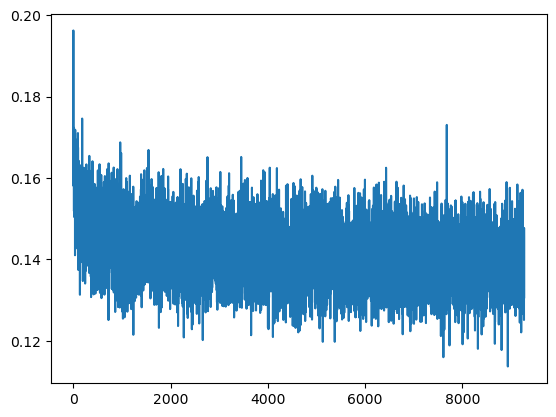

In [25]:
_ = plt.plot(loss_logger[100:])
print("Minimum MSE loss %.4f" % np.min(loss_logger))

## Using Model

In [26]:
# Set the model to evaluation mode
mha_model.eval()

# Perform forward pass without gradient computation
with torch.no_grad():
    # Reshape input data and move it to the specified device
    q_img = data.reshape(data.shape[0], 1, -1).to(device)

    # Perform forward pass through the Multi-Head Attention model
    attn_output, attn_output_weights = mha_model(q_img, values_tensor)

In [27]:
# For a given input, use the attention map to find the "closest" value-data matches
index = 10
top10 = attn_output_weights[index, 0].argsort(descending=True)[:10]
top10_data = values_tensor[index, top10].cpu()

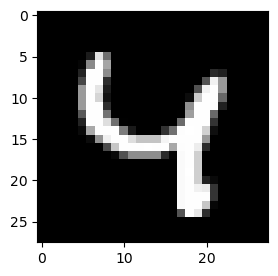

In [28]:
# Plot the original image
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(q_img[index].cpu().reshape(-1, 1, 28, 28), 8, 
                                  normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

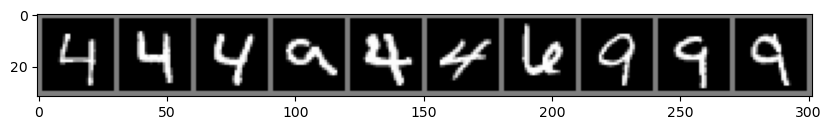

In [29]:
# Plot the top 10 closest matches
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(top10_data.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

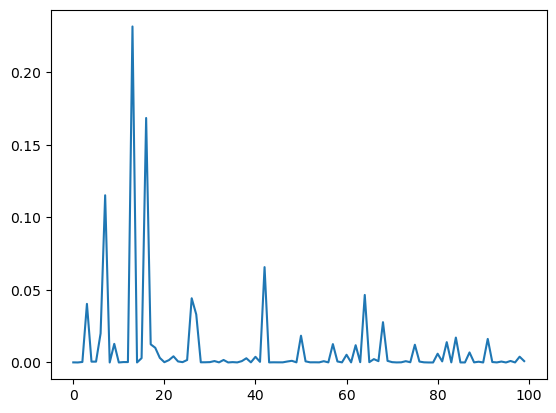

In [30]:
# Plot the attention weights for the given input
_ = plt.plot(attn_output_weights[index, 0].cpu().numpy().flatten())

In [31]:
# Reshape the target and returned images
target_img = q_img.reshape(batch_size, 1, 28, 28)
indexed_img = attn_output.reshape(batch_size, 1, 28, 28)

# Stack the images with the returned image on top
img_pair = torch.cat((indexed_img, target_img), 2).cpu()

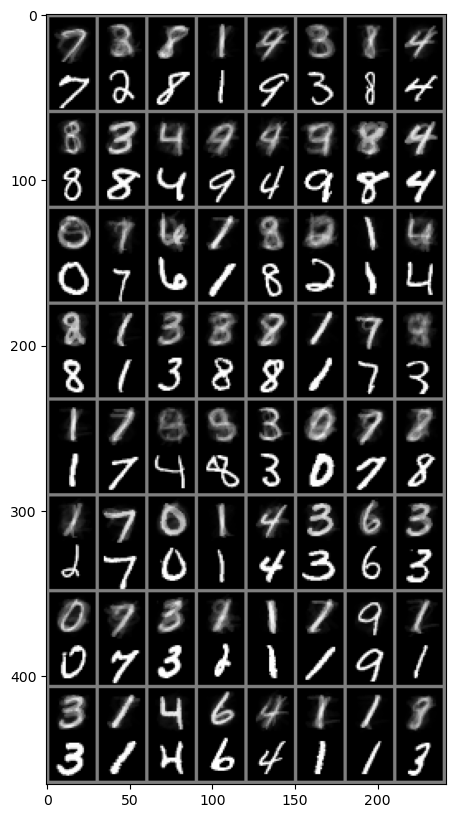

In [32]:
# Let's visualize the pairs of images, with the returned image on top and the target on bottom
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(img_pair, 8, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))